In [1]:
# Setup
import numpy as np
import os
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader, random_split, TensorDataset
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
# Global Hyper parameters & dataset choice (for training)
dataFolder  = "Data/Training/Base_Isolated_Moment_Frame_with_Impact_on_Steel_Moat_Wall" # Reads all files in that folder (INCLUDING ALL SUBDIRECTORIES) and combines into one dataset
model_dir   = 'Models' # Model saving path
lazy_load   = False # Toggle lazy file loading. If set True, the code loads each file on-the-go to save RAM. Could cause severe lagging if not actually needed. 
dt          = 0.0004 # 0.0004 for two with hitting, 0.00039 for two without. Will become smart in the future but just manual at this limited time

trim_data   = True # If True, trims all data to [index(the_first(|ground_motion| > trim_static_tol)), the_first(|ground_motion| < trim_static_tol, from back) + trim_rem]
trim_static_tol = 0.006 # Static tolerance for trimming. 
trim_rem    = 5000 # Time steps to append onto the trimmed data, in case interested in reaction after ground motion. The whole trimming is to save RAM though. Be careful not to set this too high. 

scaleParams = True # "Normalization" but since this set in inheritely unbounded
paramScaler = np.array([0.5, 10, 10000, 200, 200, 20000]) # Assumes this corresponds to all parameters in input data ('aextx','Gap','Kh','Damping','M','K'). APPLIES BY inputData/paramScaler
bypass_dep  = 1 # Bypass network output "weight". 
# Note all pre-trained models were trained under paramScaler = np.array([0.5, 10, 10000, 200, 200, 20000]) and bypass_dep  = 1. (scaleParams = True)

In [ ]:
# Algorithm toggles 
# Enabling all at once may overload the RAM
enable_mlp = True
enable_transformer = False # Take A LOT of RAM to produce anything useful
enable_cnn = False

enable_PINN = False # PINN appends onto the current algorithm (WIP. Is currently buggy) 

In [ ]:
# Define data loaders (structure inspired by Alex Simonyan's code)
# Define columns 
time_column = 'Time'
predictor_columns = ['aextx','Gap','Kh','Damping','M','K']
target_columns = ['ACCs2', 'ACCs3', 'ACCs4', 'ACCs5', 'FC']
input_dim = len(predictor_columns)
output_dim = len(target_columns)
all_files = []
sensorNames = target_columns # For plotting

for root, _, files in os.walk(dataFolder): # Reads all sub-directories
    for file in files:
        if file.endswith(".txt"):
            all_files.append(os.path.join(root,file))


In [5]:
# Random helper functions
def lastL(a):
  """Returns the last dimension of a tensor"""
  if len(a.shape) == 1:
    return a.shape[0]
  else:
    return a.shape[-1]

def isTensPercent(i, max): 
  """Returns if i is x*10% of max, where x is an integer"""
  return i % np.floor(max/10) == 0

def sychData(time1, time2, data2, defVal=0): 
  """Converts data2 under time2 to time1 using linear approaximation. REQUIRES time2.shape[0] == data2.shape[last] and time1 and time2 sorted in incrementing order with the same 0 reference point. 
  If time2 does not fully cover time1, the rear uncovered part will be trimmed, and the front uncovered part will be filled with defVal (default 0)
  
  Parameters
  -------
  time1 : 1xn np.array
  Time stamps you wish to convert into

  time2 : 1xm np.array
  Time stamps of data2

  data2 : axbx...xm np.array
  Data to be converted. Linear approaximation is computed element-wise. 

  defVal : float or np.array broadcast-able to shape of data2 with last length replaced with length of time1
  Default value to be used for not-covered part

  Throws
  -------
  sychData exception : There is no overlap between data time stamps
  When time1 and time2 do not overlap
  """
  # Initialize variables
  l = time1.shape[0]
  l2 = lastL(data2)
  size2 = data2.shape
  d1p = np.zeros(len(size2)) # Obtain shape of data1 using shape of data2 ang replacing last value with desired length
  for i in range(len(size2)-1): 
    d1p[i] = size2[i]
  d1p[len(size2)-1] = l
  data1 = np.ones(d1p.astype(int)) * defVal
  j = 0
  uncoveredSince = l
  ini = 0

  # Detect start point
  while ini < l: 
    if time2[0] <= time1[ini] <= time2[lastL(data2)-1]: 
      break
    ini += 1
  if ini >= l:
    print('sychData exception: There is no overlap between data time stamps.')
    return 0
  
  # Sychronize by linear approaximation
  for i in range(ini,l): 
    while j < l2: 
      if j == l2-1: 
        uncoveredSince = i
        break
      if time2[j] <= time1[i] <= time2[j+1]: 
        dt = time2[j+1] - time2[j]
        data1[...,i] = data2[...,j] + (data2[...,j+1] - data2[...,j]) * (time1[i] - time2[j])/dt
        break
      j += 1
  return data1[...,0:uncoveredSince]

def ppl(a,aa):
  """Debugging print shortcut"""
  print(a,':\n',aa)

In [6]:
# Fourier Transform (WIP)
# To be implemented and examined

In [7]:
# Load data functions
# Load file credit @Alex Simonyan
def loadFile(file_path, time_column, predictor_columns, target_columns):
    """Load file function wrapper. ASSUMES you pass in a .txt file of suitable format."""
    inputData = []
    sensorData = []
    timeStamps = []
    try:
        df = pd.read_csv(file_path, sep=r'\s+', engine='python')
        if all(col in df.columns for col in predictor_columns + target_columns + [time_column]):
            df_clean = df[[time_column] + predictor_columns + target_columns].dropna()
            inputData = df_clean[predictor_columns]
            sensorData = df_clean[target_columns]
            timeStamps = df_clean[time_column]
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
    return np.array(timeStamps), np.array(inputData), np.array(sensorData)

def trimData(timeStamps, inputData, outputData): 
    """Trims data as specified on the top, based on inputData[...,0]. Is theoratically slow but could save a lot of time and RAM later.
        Supports ONLY 1 file input each time.
        Samples the offset from the first and last 100 data points and uses that as the center when computing trim criteria.
    """
    maxl = len(inputData)
    c1 = np.average(inputData[:100,0])
    c2 = np.average(inputData[maxl-100:,0])
    trim_start = 0
    trim_end = maxl
    for i in range(100, maxl): 
        if np.abs(inputData[i,0]-c1) > trim_static_tol: 
            trim_start = i
            break
    for i in range(100, maxl): 
        if np.abs(inputData[maxl-i-1,0]-c2) > trim_static_tol:
            trim_end = maxl-i
            break
    trim_end = np.min([maxl,trim_end+trim_rem])
    return timeStamps[trim_start:trim_end], inputData[trim_start:trim_end], outputData[trim_start:trim_end]

def toNumpyHelper(timeRaw, inputRaw, sensorRaw, file_count, predictor_columns, target_columns, max_length=-1):
    if max_length == -1: 
        max_length = len(timeRaw)
    if file_count <= 1: 
        ts = np.array(timeRaw)
        timeStamps = np.ones([1, max_length]) * np.max(ts, axis=-1)
        inputData = np.zeros([1, max_length, len(predictor_columns)])
        sensorData = np.zeros([1, max_length, len(target_columns)])
        # print('tms:',timeStamps.shape)
        # print('ltr:',len(timeRaw))
        # print('ts:',ts.shape)
        timeStamps[0,:len(timeRaw)] = ts
        inputData[0,:len(inputRaw)] = np.array(inputRaw)
        sensorData[0,:len(sensorRaw)] = np.array(sensorRaw)
    else: 
        timeStamps = np.zeros([file_count, max_length])
        inputData = np.zeros([file_count, max_length, len(predictor_columns)])
        sensorData = np.zeros([file_count, max_length, len(target_columns)])
        for i in range(file_count): 
            timeStamps[i,:len(timeRaw[i])] = timeRaw[i]
            if len(timeRaw[i]) < timeStamps.shape[1]:
                timeStamps[i,len(timeRaw[i]):] = timeRaw[i][len(timeRaw[i])-1]
            inputData[i,:len(inputRaw[i])] = inputRaw[i]
            sensorData[i,:len(sensorRaw[i])] = sensorRaw[i]
    return timeStamps, inputData, sensorData

In [8]:
# Create samples
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor # type: ignore
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor # type: ignore
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor # type: ignore
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor # type: ignore
Tensor = FloatTensor

# Convert data to usable format
def createSamples(inputData, outputData, lookBack, normalize=False):
    dataX = []
    dataY = []
    X_max = np.max(inputData, axis=0) + 1e-12 # avoid /0
    Y_max = np.max(outputData, axis=0) + 1e-12 
    din = inputData
    dout = outputData
    T, B = din.shape
    if lookBack <= 0: 
        dataX = din
        dataY = dout
    else:
        for t in range(T-lookBack):
            x = din[t:t+lookBack,:]
            y = dout[t]
            dataX.append(x)
            dataY.append(y)
    X = np.array(dataX)
    Y = np.array(dataY)
    return Tensor(X), Tensor(Y), X_max, Y_max


In [9]:
# Lazy data loader
def getXY(file_path, lookback, returnTime=False):
    timeStamps, inputData, sensorData = loadFile(file_path, time_column, predictor_columns, target_columns)
    if trim_data: 
        timeStamps, inputData, sensorData = trimData(timeStamps, inputData, sensorData)
    if scaleParams: 
        inputData = inputData/paramScaler
    X, y, X_max, y_max = createSamples(inputData, sensorData, lookback)
    if returnTime: 
        return timeStamps,X,y
    return X,y

In [10]:
# Not lazy loading data
def getXYs(lookback): 
    Xs = []
    ys = []
    for file in all_files: 
        x, y = getXY(file, lookback)
        Xs.append(x.cpu())
        ys.append(y.cpu())
    Xs = np.concatenate(Xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return Tensor(Xs), Tensor(ys)

In [11]:
# PINN
class PINNloss(nn.Module): 
    def __init__(self, ICLoss, BCLoss, EQLoss, lambIC, lambBC, lambEQ) -> None:
        super(PINNloss, self).__init__()
        assert lambBC+lambIC+lambEQ < 1
        self.MSELoss = nn.MSELoss()
        self.lambMSE = 1 - (lambBC+lambIC+lambEQ)
        self.ICLoss = ICLoss
        self.lambIC = lambIC
        self.BCLoss = BCLoss
        self.lambBC = lambBC
        self.EQLoss = EQLoss
        self.lambEQ = lambEQ

    def forward(self, z, y, y_pred): 
        mse = self.MSELoss(y, y_pred) * self.lambMSE
        ic = self.ICLoss(z, y_pred) * self.lambIC
        bc = self.BCLoss(z, y_pred) * self.lambBC
        eq = self.EQLoss(z, y_pred) * self.lambEQ
        err = mse+ic+bc+eq
        return err

# PINN calculation functions
def linIntp(prevs, nexts, numPt): 
    """Linearly interpolate from prevs to nexts for numPt points (e.g. linIntp([1,2,3],[4,5,6],2) -> [2,3,3,4,4,5])
    ASSUMES prevs.shape == nexts.shape or otherwise broadcastable"""
    diff = nexts - prevs
    dx = diff / (numPt+1)
    out = []
    for i in range(1, numPt+1): 
        out.append(prevs+dx*i)
    return torch.concatenate(out, dim=0)

def rectInt(dt, ys): 
    """Assumes ys is already well-prepared for centual integration"""
    out = [ys[0]]
    for i in range(1, len(ys)-1): 
        if math.isnan(ys[i]): 
            out.append(out[i-1])
        else: 
            out.append(out[i-1]+ys[i])
    return Tensor(out)*2*dt

def trapInt(dt, ys): 
    """Assumes ys is already well-prepared"""
    out = [ys[0]+ys[1]]
    for i in range(1, len(ys)-1): 
        if math.isnan(ys[i]): 
            out.append(out[i-1])
        else: 
            out.append(out[i-1]+ys[i-1]+ys[i])
    return Tensor(out)*dt #*2/2

def simpson(dt, ys:Tensor): 
    """Note integrateion here outputs a Tensor of integrated results over time steps of ys"""
    if len(ys) % 2 != 0: 
        if len(ys.shape) <= 1: 
            zro = Tensor([0],device=device)
        else:
            zro = Tensor(np.zeros(ys.shape[1:]),device=device)
        return simpson(dt, torch.concatenate((ys,zro),dim=0))
    ysm = ys
    i1 = torch.arange(0,len(ysm),2)
    i2 = torch.arange(1,len(ysm),2)
    i3 = torch.arange(2,len(ysm),2)
    rtn = torch.zeros_like(ysm)
    rtn[i3] = (2*rectInt(dt, ysm[i2]) + trapInt(dt, ysm[i1])) / 3
    i4 = torch.arange(0,len(ysm)-2,2)
    i5 = torch.arange(1,len(ysm)-2,2)
    rtn[i5] = linIntp(rtn[i4], rtn[i3], 1)
    return rtn
    
def computeZ(params, y_pred): 
    # X, y_pred -> dx, velo, provided acc in g and t in s
    up = simpson(dt, y_pred*9.81)
    u = simpson(dt, up)
    return [u, up, params]

def ICLoss(z, y_pred): # Not really a DE with IC and BC
    return 0

def BCLoss(z, y_pred): 
    return 0

def EQLoss(z, y_pred): 
    # u, u' -> FC, FC - y_pred
    u, up, params = z
    u = torch.abs(u)
    if u[-2] != 0: 
        u -= torch.arange(0,u[-2],u[-2]/u.shape[0], device=device)[:u.shape[0]] # Attempt to cancel out accumulative error by numerical integration in a simple way
    up = torch.abs(up)
    if up[-2] != 0:
        up -= torch.arange(0,up[-2],up[-2]/up.shape[0], device=device)[:up.shape[0]]
    xi = params[2]*paramScaler[2]/100
    Kh = params[1]*paramScaler[1]*1e6
    gap = params[0]*paramScaler[0]*0.0254
    mx, _ = torch.max(torch.stack([u - gap, torch.zeros_like(u)], dim=0), dim=0)
    msk = torch.sign(mx)
    Ch = xi * torch.pow(u,3.0/2)
    Fc = Kh * torch.pow(u,3.0/2) + Ch*(up)
    Fc = Tensor(Fc * msk)*0.000224808943
    return torch.sum(Fc[:len(y_pred)]-y_pred[...,-1])**2


In [12]:
# Training / Eval functions
def getMsk(X, device): 
    return nn.Transformer.generate_square_subsequent_mask(X.shape[1], device=device.type)

def toChannels(X, channels): 
    """Splits X (BxFxS) to (B/channels)x(channelsxFxS) sets. If X%channels != 0, pad the last ones with zero."""
    rem = X%channels 
    out = []
    i = 0
    while i < X.shape[0]: 
        out.append(X[i:i+channels])
        i += channels
    if rem > 0: 
        zeros = np.zeros([rem, X.shape[1], X.shape[2]])
        out.append(np.concatenate([X[i:],zeros],axis=0))
    return torch.Tensor(out)


def train(model, optimizer, dataloader, loss_func, device, use_mask=False, channels=1, PINN=False, ts=None): 
    #TODO: ts reserved for dynamic time step integration in PINN. Currently just use a set step size
    model.train()
    total_mse, total_count = 0, 0
    for idx, (X, y) in enumerate(dataloader):
        if channels > 1: 
            X = toChannels(X, channels)
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if use_mask:
            y_pred = model.forward(X, getMsk(X, device))
        else:
            y_pred = model.forward(X)
        if PINN: 
            if math.isnan(y_pred[0,0]): 
                continue
            z = computeZ(X[0,0,1:], y_pred[...,0])
            loss = loss_func(z, y, y_pred)
        else:
            loss = loss_func(y, y_pred)
        loss.backward()

        optimizer.step()
        total_mse += loss.item()
        total_count += X.size(0)
    return total_mse / total_count    

def evaluate(model, dataloader, loss_func, device, PINN=False, use_mask=False, channels=1, ts=None):
    model.eval()
    total_mse, total_count = 0, 0

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            if channels > 1: 
                X = toChannels(X, channels)
            X = X.to(device)
            y = y.to(device)
            if use_mask: 
                y_pred = model.forward(X, getMsk(X, device))
            else:
                y_pred = model.forward(X)
            if PINN: 
                if math.isnan(y_pred[0,0]): 
                    loss = 0
                    continue
                z = computeZ(X[0,0,1:], y_pred[...,0])
                loss = loss_func(z, y, y_pred)
            else:
                loss = loss_func(y, y_pred)

            total_mse += loss.item()
            total_count += X.size(0)
    return total_mse/total_count

In [13]:
# MLP class 
class MLPModel(nn.Module):
    """
    A simple MLP‐based predictor that flattens the entire input sequence.
    """
    def __init__(self, input_dim: int, seq_len: int, hidden_dim: int, output_dim: int, hidden_layers = 0, activation = nn.ReLU(), flat = 1):
        """
        - input_dim:   feature dimension at each time step
        - seq_len:     number of time steps in the sequence
        - hidden_dim:  width of the hidden MLP layer
        - output_dim:  dimension of the prediction
        """
        super(MLPModel, self).__init__()
        self.flat = flat
        if flat >= 0:
            self.flatten = nn.Flatten(start_dim=flat)
        if hidden_layers < 0: 
            self.layers = nn.Linear(input_dim*seq_len, output_dim)
            return
        self.layers = nn.Sequential(
            nn.Linear(input_dim*seq_len, hidden_dim),
            activation
        )
        for i in range(hidden_layers): 
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(activation)
        self.layers.append(nn.Linear(hidden_dim, output_dim))
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [batch_size, seq_len, input_dim]
        returns y: [batch_size, output_dim]
        """
        # DONE: process your input
        if self.flat >= 0:
            z = self.flatten(x)
        else: 
            z = x
        y = self.layers(z)
        return y
    

In [14]:
# MLP with a bypass
class MLPwizBypass(nn.Module): 
    def __init__(self, input_dim: int, seq_len: int, hidden_dim: int, output_dim: int, bypass_hidden_dim = 32, bypass_hidden_layers = 0, hidden_layers = 0, activation = nn.ReLU()):
        super(MLPwizBypass, self).__init__()
        self.main = MLPModel(1, seq_len, hidden_dim, output_dim, hidden_layers, activation)
        self.bypass = MLPModel(input_dim-1, 1, bypass_hidden_dim, output_dim, bypass_hidden_layers, activation, flat=0)
        self.out = MLPModel(output_dim, 2, 1, output_dim, -1, activation)

    def forward(self, X: Tensor): 
        y = self.main(X[...,0])
        z = bypass_dep*self.bypass(X[0,0,1:])
        z = torch.ones_like(y)*z
        rtn = self.out(torch.concat([y,z],dim=1))
        return rtn

In [ ]:
# MLP experiment (Main structure from ECE228 HWs)
if enable_mlp: 
    # Settings 
    batch_size  = 20000 # Number of points
    term_tol    = 10 # Maximum number of epochs the model is allowed to run for without achieving a smaller validation error
    epochs      = 100 # epochs maximum (has early termination)

    # Hyper parameters for MLP
    look_back           = 2048 # "History" to take into account
    mlp_lr              = 1e-4 # Learning rate
    mlp_hidden_dim      = 4096 # Hidden size. Ignored if mlp_hidden_layers = -1
    mlp_hidden_layers   = 4 # Hidden layers (in addition to input and output layers. Use -1 to form a single layer network.)
    bypass_hidden_dim   = 16 # Hidden specs of the bypass network for static parameters
    bypass_hidden_layers = 4 

    # Hyper parameters for PINN 
    if enable_PINN:
        lambIC = 0
        lambBC = 0
        lambEQ = 0.1
        print('Expected lambMSE = ', 1-lambIC-lambBC-lambEQ)
        assert 1-lambIC-lambBC-lambEQ > 0

    # Initialization
    if not lazy_load: 
        Xs,ys = getXYs(look_back)
        dataset            = TensorDataset(Xs, ys)
        train_size         = int(0.8*len(dataset))
        val_size           = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        a = torch.utils.data.SequentialSampler(dataset)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    train_mse_MLP = []
    val_mse_MLP = []
    model = MLPwizBypass(input_dim, look_back, mlp_hidden_dim, output_dim, bypass_hidden_dim, bypass_hidden_layers, hidden_layers=mlp_hidden_layers)
    # model = MLPModel(input_dim,look_back, mlp_hidden_dim, output_dim, mlp_hidden_layers) # Sometimes (especially when layer size is small) the bypass layer causes weird stuff. Try using standard MLP if you get a huge constant offset in the output. 
    model.to(device)
    if enable_PINN: 
        loss_func = PINNloss(ICLoss, BCLoss, EQLoss, lambIC, lambBC, lambEQ) 
    else:
        loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.AdamW(model.parameters(), lr=mlp_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, mlp_lr*1e-2)
    best_mse = 1e24
    total_mse = None
    train_mse_lst = []
    val_mse_lst = []
    term_count = 0
    best_state_dicts = model.state_dict()

    print('Start of training')
    for epoch in range(1, epochs + 1):
        term_count += 1
        epoch_start = time.time()
        mse_train_e = 0
        mse_val_e = 0

        if lazy_load: 
            for file in all_files: 
                # Lazy load data
                X,y = getXY(file, look_back)
                dataset            = TensorDataset(X, y)
                train_size         = int(0.8*len(dataset))
                val_size           = len(dataset) - train_size
                train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
                a = torch.utils.data.SequentialSampler(dataset)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

                # Real training
                mse_train = train(model, optimizer, train_loader, loss_func, device)
                mse_val = evaluate(model, val_loader, loss_func, device, PINN=enable_PINN)
                mse_train_e += mse_train
                mse_val_e += mse_val
        else: 
            mse_train = train(model, optimizer, train_loader, loss_func, device, PINN=enable_PINN)
            mse_val = evaluate(model, val_loader, loss_func, device, PINN=enable_PINN)
            mse_train_e += mse_train
            mse_val_e += mse_val

        train_mse_lst += [mse_train_e]
        val_mse_lst += [mse_val_e]
        if total_mse is not None and total_mse > mse_val_e:
            scheduler.step()
        else:
            total_mse = mse_val_e
        
        if isTensPercent(epoch, epochs) or epoch <= 5:
            print('-' * 59)
            print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s/epoch | valid mse {mse_val:8.3e} ')
        
        # Save best model & early termination
        if mse_val_e < best_mse:
            best_state_dicts = model.state_dict()
            best_mse = mse_val_e
            term_count = 0
        if term_count > term_tol: 
            break
    model.load_state_dict(best_state_dicts)
    torch.save(model, os.path.join(model_dir, 'mlp'))
    train_mse_MLP.append(train_mse_lst)
    val_mse_MLP.append(val_mse_lst)
            

Start of training
-----------------------------------------------------------
| end of epoch   1 | time:  5.26s/epoch | valid mse 3.662e-05 
-----------------------------------------------------------
| end of epoch   2 | time:  4.55s/epoch | valid mse 3.313e-05 
-----------------------------------------------------------
| end of epoch   3 | time:  4.54s/epoch | valid mse 1.903e-05 
-----------------------------------------------------------
| end of epoch   4 | time:  4.56s/epoch | valid mse 8.566e-06 
-----------------------------------------------------------
| end of epoch   5 | time:  4.41s/epoch | valid mse 6.674e-06 
-----------------------------------------------------------
| end of epoch   6 | time:  4.44s/epoch | valid mse 5.946e-06 
-----------------------------------------------------------
| end of epoch   8 | time:  4.42s/epoch | valid mse 4.198e-06 
-----------------------------------------------------------
| end of epoch  10 | time:  4.39s/epoch | valid mse 3.200e-06

In [16]:
# Positional encoding
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim
        self.max_len = max_len

    def forward(self, x):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]
        self.max_len = np.max([self.max_len,seq_len])

        pe = np.zeros([seq_len,input_dim])
        poses = np.arange(seq_len, dtype=np.float32)
        for i in range(0,input_dim,2): 
            pe[:,i] = np.sin(poses/np.power(self.max_len,i/input_dim))
        for i in range(1,input_dim,2): 
            pe[:,i] = np.cos(poses/np.power(self.max_len,(i-1)/input_dim))
        pe = torch.as_tensor(pe, dtype=torch.float32)

        x = x + pe.to(x.device)
        return x

In [17]:
# Modifed Transformer Structure. Structure credit @Prof. Yuanyuan Shi
# Uses a transformer to predict the ground motion effect and a bypass network for effect of parameters
class TransformerPredictor(nn.Module):
    """
    Trnasformer encoder with an output layer
    """
    def __init__(self, input_dim: int, seq_length: int, num_heads: int, ff_dim: int, num_layers: int, output_dim: int, mlp_hidden_dim: int, mlp_hidden_layers: int, bypass_dim: int, bypass_hidden: int, dropout = 0.1, norm_first = True):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerPredictor, self).__init__()
        self.pe = PositionalEncoding(input_dim, seq_length)
        # self.bypass = MLPModel(input_dim-1, 1, bypass_dim, seq_length, bypass_hidden)
        el = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True, norm_first=norm_first, dropout=dropout)
        self.enc = nn.TransformerEncoder(el, num_layers=num_layers)
        dc = nn.TransformerDecoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True, norm_first=norm_first, dropout=dropout)
        self.dec = nn.TransformerDecoder(dc, num_layers=num_layers)
        self.out = MLPModel(input_dim, seq_length, mlp_hidden_dim, output_dim, hidden_layers=mlp_hidden_layers)

    def forward(self, x: torch.Tensor, tgt_mask: None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the decoder
        """
        # z = bypass_dep*self.bypass(x[...,0,1:]) # Assumes static parameters
        z = self.pe(x)
        y = self.enc(z) 
        if tgt_mask is not None: 
            y = self.dec(x, y, tgt_mask = tgt_mask, memory_mask = tgt_mask)
        else:
            y = self.dec(x, y)
        y = self.out(y)
        return y


In [18]:
# Transformer experiment (Okay. Not enough RAM to perform anything useful)
if enable_transformer: 
    # Settings
    batch_size      = 128 # Number of points to predict at the same time
    term_tol        = 10 # Maximum number of epochs the model is allowed to run for without achieving a smaller validation error
    epochs          = 10 # Epochs maximum (has early termination)
    look_back       = 128 

    # Hyper parameters for Transformer
    trx_lr = 1e-4 # learning rate
    num_heads = 1
    num_trx_cells = 1 #2
    trx_num_layers = 1 #2
    trx_ff_dim = 32 #64
    trx_hidden_dim = 32 #256
    trx_hidden_layers = 1 #2
    bypass_dim = 64 # Hidden dimension of bypass MLP that processes static parameters (to reduce workload of transformer -- running everthing in transformer could take forever)
    bypass_hidden = 4 # Hidden layers of bypass MLP. Set -1 to use a single layer
    dropout = 0.1
    print('Each head receives',input_dim/num_heads,'features.')
    assert input_dim/num_heads == input_dim//num_heads

    # Initialization
    if not lazy_load: 
        Xs,ys = getXYs(look_back)
        dataset            = TensorDataset(Xs, ys)
        train_size         = int(0.8*len(dataset))
        val_size           = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        a = torch.utils.data.SequentialSampler(dataset)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    train_mse_TRX = []
    val_mse_TRX = []
    model = TransformerPredictor(input_dim=input_dim, seq_length=look_back, num_heads=num_heads, ff_dim=trx_ff_dim, num_layers=trx_num_layers, output_dim=output_dim, mlp_hidden_dim=trx_hidden_dim, mlp_hidden_layers=trx_hidden_layers, bypass_dim=bypass_dim, bypass_hidden=bypass_hidden, dropout = dropout, norm_first = True)
    msk = nn.Transformer.generate_square_subsequent_mask(look_back, device=device.type)
    model.to(device)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=trx_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, trx_lr*1e-2)
    best_mse = 1e24
    total_mse = None
    train_mse_lst = []
    val_mse_lst = []
    term_count = 0
    best_state_dicts = model.state_dict()

    print('Start of training')
    for epoch in range(1, epochs + 1):
        term_count += 1
        epoch_start = time.time()
        mse_train_e = 0
        mse_val_e = 0

        if lazy_load:
            for file in all_files: 
                # Lazy load data
                X,y = getXY(file, look_back)
                dataset            = TensorDataset(X, y)
                train_size         = int(0.8*len(dataset))
                val_size           = len(dataset) - train_size
                train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
                a = torch.utils.data.SequentialSampler(dataset)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

                # Real training
                mse_train = train(model, optimizer, train_loader, loss_func, device, use_mask=True)
                mse_val = evaluate(model, val_loader, loss_func, device, use_mask=True)
                mse_train_e += mse_train
                mse_val_e += mse_val
        else: 
            mse_train = train(model, optimizer, train_loader, loss_func, device, use_mask=True)
            mse_val = evaluate(model, val_loader, loss_func, device, use_mask=True)
            mse_train_e += mse_train
            mse_val_e += mse_val
            
        train_mse_lst += [mse_train_e]
        val_mse_lst += [mse_val_e]
        if total_mse is not None and total_mse > mse_val_e:
            scheduler.step()
        else:
            total_mse = mse_val_e
        
        if isTensPercent(epoch, epochs) or epoch <= 5:
            print('-' * 59)
            print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s/epoch | valid mse {mse_val:8.3e} ')
        
        # Save best model & early termination
        if mse_val_e < best_mse:
            best_state_dicts = model.state_dict()
            best_mse = mse_val_e
            term_count = 0
        if term_count > term_tol: 
            break
    model.load_state_dict(best_state_dicts)
    torch.save(model, os.path.join(model_dir, 'trx'))
    train_mse_TRX.append(train_mse_lst)
    val_mse_TRX.append(val_mse_lst)



In [ ]:
# Debugger class to print things out
class debugger(nn.Module): 
    def __init__(self, msg): 
        super(debugger,self).__init__()
        self.msg = msg
    def forward(self,X,msk=None,whatever=None,justAnotherPlaceHolder=None): 
        # print(self.msg)
        # print(X.shape)
        return X

In [20]:
# CNN classes
class ConvBlock(nn.Module):
    """
    A convolutional block with a 1D convolution, batch normalization, and ReLU activation.
    """
    def __init__(self, in_channels, mid_channels, mid_conv_layers, out_dim,
                 ff_hidden_dim, ff_hidden_layers=0, 
                 kernel_size=3, stride=1, padding=1, pool_size=2, activation=nn.ReLU()):
        super(ConvBlock, self).__init__()
        # c = in_channels
        # print('len:',c)
        if pool_size > 0:
            pool = nn.MaxPool1d(kernel_size=pool_size)
        self.layers = nn.Sequential(
            # debugger('start'),
            nn.Conv1d(in_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            # debugger('first activetion'),
            activation
        )
        # c = (c-kernel_size+2*padding)/stride + 1
        # print('len:',c)
        if pool_size > 0: 
            self.layers.append(debugger('first pool'))
            self.layers.append(pool)
            # c = c/pool_size
        for i in range(mid_conv_layers): 
            # self.layers.append(debugger(str(i)+'th conv'))
            self.layers.append(nn.Conv1d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            # self.layers.append(debugger(str(i)+'th activation'))
            self.layers.append(activation)
            # c = (c-kernel_size+2*padding)/stride + 1
            # print('len:',c)
            if pool_size > 0: 
                # self.layers.append(debugger(str(i)+'th pool'))
                self.layers.append(pool)
                # c = c/pool_size
        self.layers.append(debugger('output'))
        self.layers.append(MLPModel(mid_channels, 1, ff_hidden_dim, out_dim, hidden_layers=ff_hidden_layers, activation=activation))
    
    def forward(self, x):
        return self.layers(x)
    
class CNNModel(nn.Module): 
    """
    A simple CNN-based predictor. Uses a bypass MLP to handle static parameters as well.
    """
    def __init__(self, input_channels: int, mid_channels: int, output_dim: int, input_dim: int, 
                 bypass_hidden_dim=32, bypass_hidden_layers=-1, 
                 mid_conv_layers=0, ff_hidden_dim=0, ff_hidden_layers=0, 
                 kernel_size=3, stride=1, padding=1, pool_size=2, activation=nn.ReLU()):
        super(CNNModel, self).__init__()
        # self.debug = debugger('CNNModel:')
        self.bypass_mlp = MLPModel(input_dim-1, 1, bypass_hidden_dim, output_dim, bypass_hidden_layers, activation, flat=0)
        self.conv = ConvBlock(input_channels, mid_channels, mid_conv_layers, output_dim, ff_hidden_dim, ff_hidden_layers, kernel_size, stride, padding, pool_size, activation)
        self.out = MLPModel(output_dim, 2, ff_hidden_dim, output_dim, ff_hidden_layers, activation)

    def forward(self, x):
        # self.debug(x)
        z = self.bypass_mlp(x[0,0,1:]) # Also assumes static parameters
        # self.debug(z)
        y = self.conv(x[...,0,:])
        z = torch.ones_like(y)*z
        # self.debug(y)
        y = self.out(torch.concat([y,z],dim=-1))
        return y

In [21]:
# CNN experiment (This thing is sloooooooooooooow)
# Papers might be interesting to look at: 
# https://journals.sagepub.com/doi/pdf/10.1177/14613484211038408
# https://onlinelibrary.wiley.com/doi/abs/10.1002/stc.2519
if enable_cnn: 
    # Settings
    batch_size  = 12000 # Number of points
    term_tol    = 10 # Maximum number of epochs the model is allowed to run for without achieving a smaller validation error
    epochs      = 10 # epochs maximum (has early termination)
    look_back   = 1024 # Input dim

    # Hyper parameters
    cnn_lr = 1e-4 # learning rate
    cnn_ff_hidden = 256 # hidden size
    cnn_ff_hidden_layers = 0
    cnn_mid_channels = 64
    cnn_mid_conv_layers = 0
    bypass_hidden_dim = 128
    bypass_hidden_layers = 4
    pool_size = -1
    kernel_size = 3
    # print('Expected output channels =',input_dim/np.power(pool_size,cnn_mid_conv_layers))
    # assert input_dim/np.power(pool_size,cnn_mid_conv_layers+1) >= 1

    # Initialization
    if not lazy_load: 
        Xs,ys = getXYs(look_back)
        Xs = Xs[:,:,:,None]
        dataset            = TensorDataset(Xs, ys)
        train_size         = int(0.8*len(dataset))
        val_size           = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        a = torch.utils.data.SequentialSampler(dataset)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
        
    train_mse_CNN = []
    val_mse_CNN = []
    # input_channels: int, mid_channels: int, output_dim: int, bypass_hidden_dim=32, bypass_hidden_layers=-1, 
    # mid_conv_layers=0, ff_hidden_dim=0, ff_hidden_layers=0, kernel_size=3, stride=1, padding=1, pool_size=2, activation=nn.ReLU()
    model = model = CNNModel(look_back, cnn_mid_channels, output_dim, input_dim,
                             bypass_hidden_dim=bypass_hidden_dim, bypass_hidden_layers=bypass_hidden_layers, 
                             mid_conv_layers=cnn_mid_conv_layers, 
                             ff_hidden_dim=cnn_ff_hidden, ff_hidden_layers=cnn_ff_hidden_layers, 
                             kernel_size=kernel_size, stride=1, padding=1, pool_size=pool_size, activation=nn.ReLU())
    model.to(device)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cnn_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, cnn_lr*1e-2)
    best_mse = 1e24
    total_mse = None
    train_mse_lst = []
    val_mse_lst = []
    term_count = 0
    best_state_dicts = model.state_dict()

    print('Start of training')
    for epoch in range(1, epochs + 1):
        term_count += 1
        epoch_start = time.time()
        mse_train_e = 0
        mse_val_e = 0

        if lazy_load: 
            for file in all_files: 
                # Lazy load data
                X,y = getXY(file, look_back)
                X = X[:,:,:,None]
                # print(X.shape)
                dataset            = TensorDataset(X, y)
                train_size         = int(0.8*len(dataset))
                val_size           = len(dataset) - train_size
                train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
                a = torch.utils.data.SequentialSampler(dataset)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

                # Real training
                mse_train = train(model, optimizer, train_loader, loss_func, device)
                mse_val = evaluate(model, val_loader, loss_func, device)
                mse_train_e += mse_train
                mse_val_e += mse_val
        else: 
            mse_train = train(model, optimizer, train_loader, loss_func, device)
            mse_val = evaluate(model, val_loader, loss_func, device)
            mse_train_e += mse_train
            mse_val_e += mse_val
        train_mse_lst += [mse_train_e]
        val_mse_lst += [mse_val_e]
        if total_mse is not None and total_mse > mse_val_e:
            scheduler.step()
        else:
            total_mse = mse_val_e
        
        if isTensPercent(epoch, epochs) or epoch <= 5:
            print('-' * 59)
            print(f'| end of epoch {epoch:3d} | time: {time.time()-epoch_start:5.2f}s/epoch | valid mse {mse_val:8.3e} ')
        
        # Save best model & early termination
        if mse_val_e < best_mse:
            best_state_dicts = model.state_dict()
            best_mse = mse_val_e
            term_count = 0
        if term_count > term_tol: 
            break
    model.load_state_dict(best_state_dicts)
    torch.save(model, os.path.join(model_dir, 'cnn'))
    train_mse_CNN.append(train_mse_lst)
    val_mse_CNN.append(val_mse_lst)
    

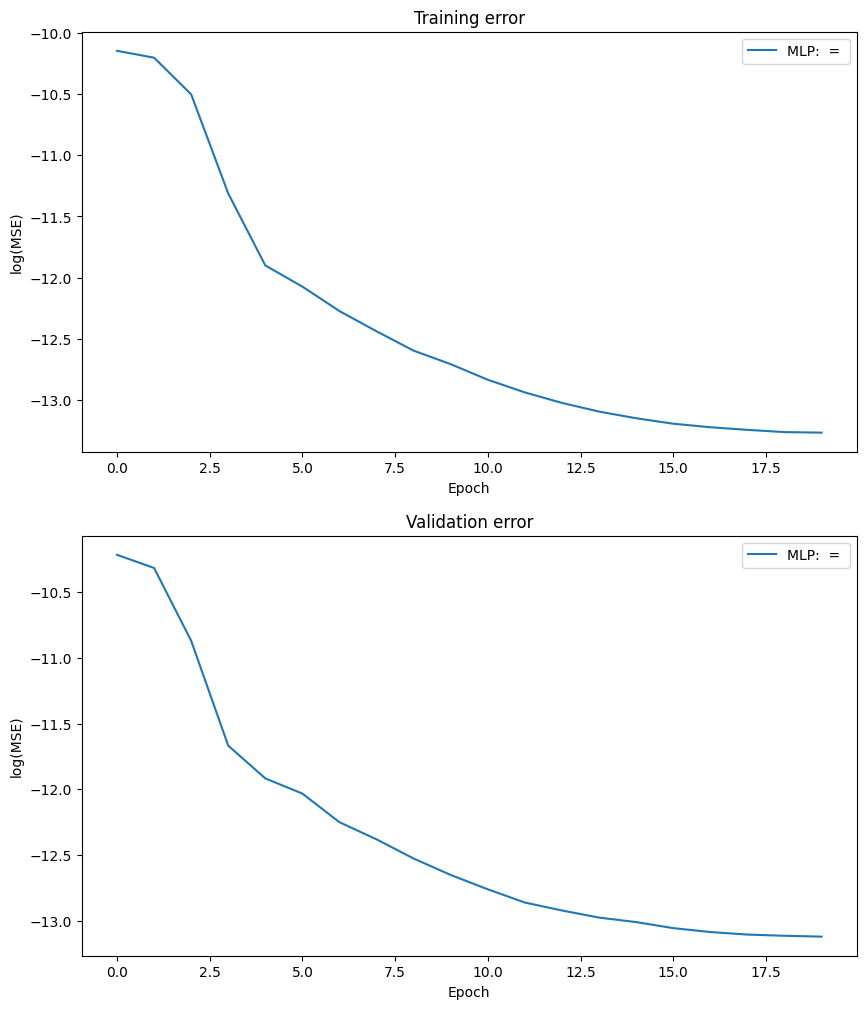

In [ ]:
# Loss plot visualization
def plotHelper(pt, specs, specVals, mse, method, log=True): 
    for i in range(len(specs)): 
        lbl = [method, ': ', specs[i], ' = ', specVals[i]]
        lbl = "".join(lbl)
        if log: 
            pt.plot(np.log(mse), label=lbl)
        else: 
            pt.plot(mse[i], label=lbl)
def pseduBroadcast(f, t): 
    """"Broadcast" f to length of t"""
    rtn = []
    for i in range(len(t)): 
        rtn.append(f)
    return rtn

fig, ax = plt.subplots(2, 1)
if enable_mlp:
    plotHelper(ax[0], [''], [''], train_mse_MLP[0], 'MLP', log=True)
if enable_transformer: 
    plotHelper(ax[0], [''], [''], train_mse_TRX[0], 'Transformer', log=True)
if enable_cnn:
    plotHelper(ax[0], [''], [''], train_mse_CNN[0], 'CNN', log=True)
ax[0].set(xlabel='Epoch', ylabel='log(MSE)', title='Training error')
ax[0].legend(loc='upper right')

if enable_mlp:
    plotHelper(ax[1], [''], [''], val_mse_MLP[0], 'MLP', log=True)
if enable_transformer: 
    plotHelper(ax[1], [''], [''], val_mse_TRX[0], 'Transformer', log=True)
if enable_cnn:
    plotHelper(ax[1], [''], [''], val_mse_CNN[0], 'CNN', log=True)
ax[1].set(xlabel='Epoch', ylabel='log(MSE)', title='Validation error')
ax[1].legend(loc='upper right')
fig.set_figheight(12)
fig.set_figwidth(10)

In [ ]:
# Load & Use the model to predict stuff and compare. Can be ran separately by toggling all algorithms as False in section 3 and choosing a pre-trained model using dataPath below.
# Settings
using_mlp = True # Manually choose type of the model
using_transformer = False
using_cnn = False
dataPath = 'Data/Testing/Base_Isolated_Moment_Frame_with_Impact_on_Steel_Moat_Wall/filtered_fp4rgm111s3_denoised.txt' 
model = torch.load(os.path.join(model_dir, 'mlp'))

def predHelper(model, pred_dataloader, use_msk=False):
    y_pred = []
    for idx, (X,y) in enumerate(pred_dataloader):
        X = X.to(device)
        if use_msk: 
            y_b = model.forward(X,getMsk(X,device))
        else:
            y_b = model.forward(X)
        y_pred.append(y_b.detach().cpu().numpy())
    if len(y_pred) == 1: 
        print('Output length == 1 detected')
        return y_pred[0]
    y_pred = np.concatenate(y_pred, axis=0)
    return y_pred

timeStamps,X,y = getXY(dataPath, look_back, returnTime=True)
print('X:',X.shape)
print('y:',y.shape)
dataset = TensorDataset(X, y)
pred_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

if using_mlp: 
    model.eval()
    y_mlp = predHelper(model, pred_dataloader)
    print('y_mlp shape generated:', y_mlp.shape)
if using_transformer: 
    model.eval()
    y_trx = predHelper(model, pred_dataloader, use_msk=True)
    print('y_trx shape generated:', y_trx.shape)
if using_cnn: 
    model.eval()
    y_cnn = predHelper(model, pred_dataloader)
    print('y_trx shape generated:', y_cnn.shape)

X: torch.Size([53550, 1024, 6])
y: torch.Size([53550, 5])
y_mlp shape generated: (53550, 5)


In [ ]:
# Post processing for plotting
y = y.detach().cpu().numpy()
carrier0 = np.zeros([len(timeStamps), output_dim])
buffer0 = y
y = carrier0
y[look_back:] = buffer0
x = X.detach().cpu().numpy()
carrier1 = np.zeros(len(timeStamps))
buffer11 = x[0,:,0]
buffer12 = x[1:,-1,0]
x = carrier1
x[:look_back] = buffer11
x[look_back:-1] = buffer12
if enable_mlp: 
    carrier = np.zeros([len(timeStamps), output_dim])
    bufferm = y_mlp
    y_mlp = carrier
    y_mlp[look_back:] = bufferm
if enable_transformer: 
    carrier = np.zeros([len(timeStamps), output_dim])
    buffert = y_trx
    y_trx = carrier
    y_trx[look_back:] = buffert
if enable_cnn: 
    carrier = np.zeros([len(timeStamps), output_dim])
    bufferc = y_cnn
    y_cnn = carrier
    y_cnn[look_back:] = bufferc

In [ ]:
# Testing out PINN (For debugging)
testPINN = False

def EQLoss2(z): 
    # u, u' -> FC, FC - y_pred
    u, up, params = z
    u = torch.abs(u)
    u -= torch.arange(0,u[-2],u[-2]/u.shape[0], device=device)[:u.shape[0]] # Attempt to cancle out accumulative error by numerical integration in a simple way
    up = torch.abs(up)
    up -= torch.arange(0,up[-2],up[-2]/up.shape[0], device=device)[:up.shape[0]]
    xi = params[2]*paramScaler[2]/100
    Kh = params[1]*paramScaler[1]*1e6
    gap = params[0]*paramScaler[0]*0.0254
    mx, _ = torch.max(torch.stack([u - gap, torch.zeros_like(u)], dim=0), dim=0)
    msk = torch.sign(mx)
    Ch = xi * torch.pow(u,3.0/2)
    Fc = Kh * torch.pow(u,3.0/2) + Ch*(up)
    Fc = Tensor(Fc * msk)*0.000224808943
    return Fc
    # return u

if testPINN: 
    z = computeZ(Tensor(X[0,0,1:]),Tensor(y[...,0]))
    fc = EQLoss2(z)
    fc = fc.detach().cpu().numpy()

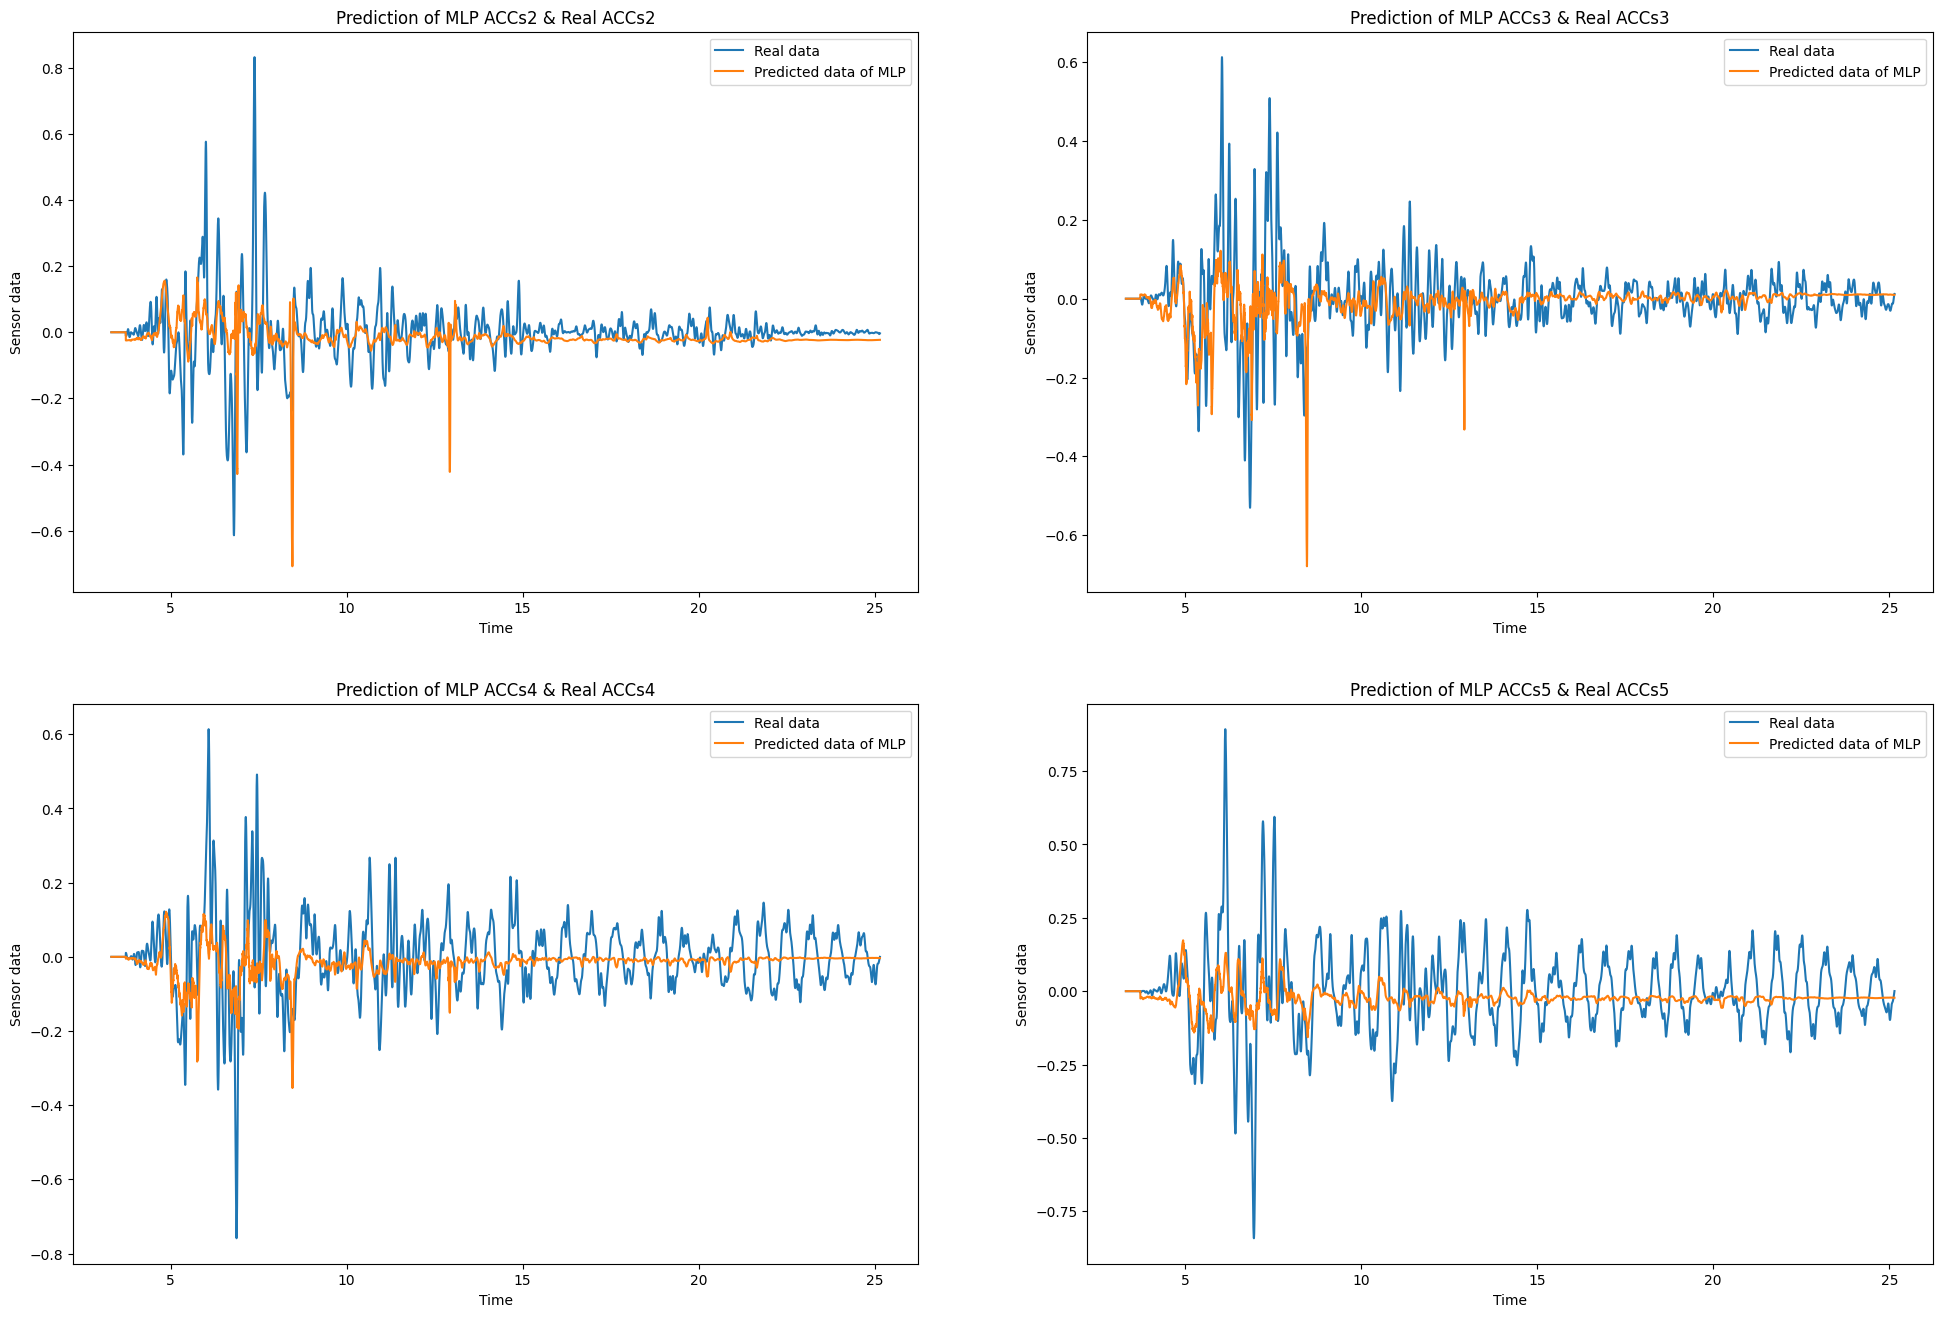

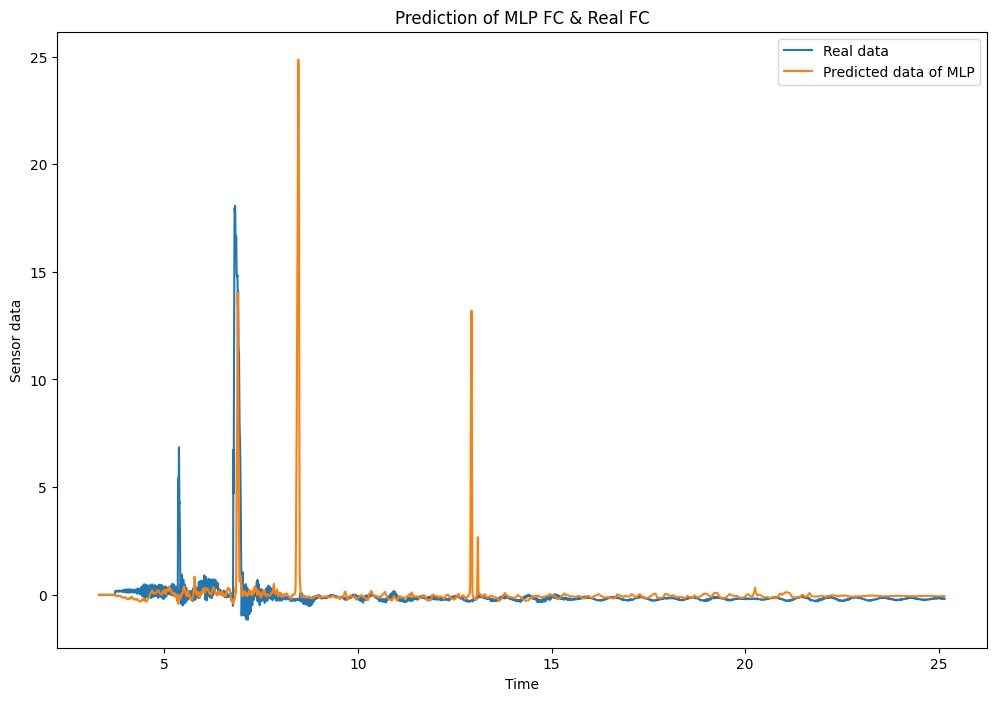

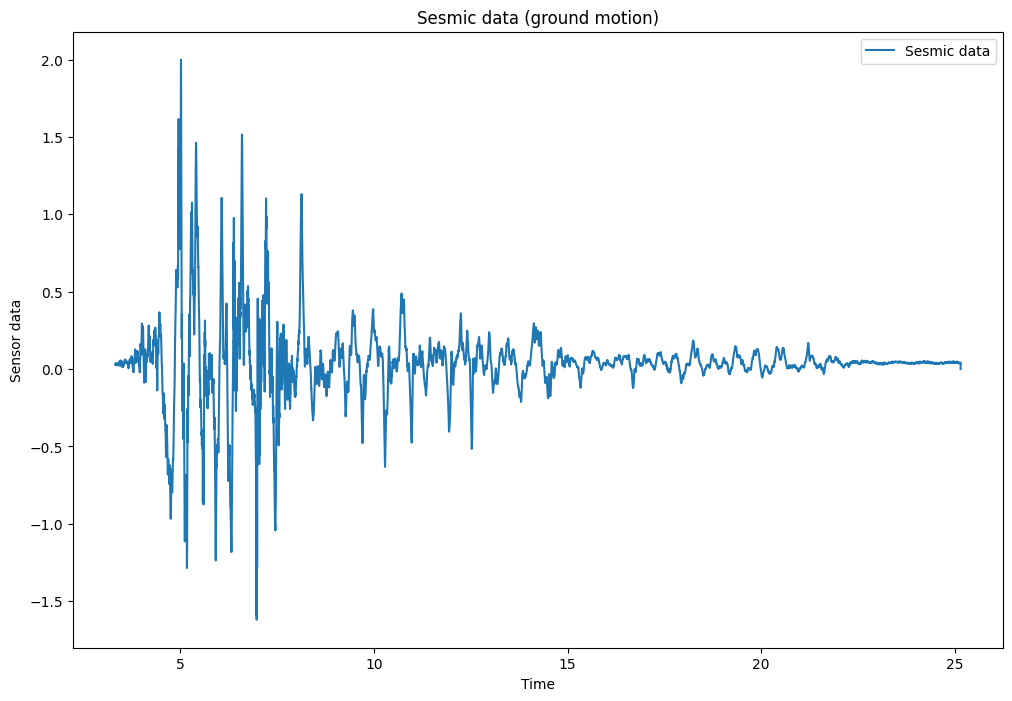

In [ ]:
# Rough realization of plotting predicted data against real data
def plotDataUnit(ax, ts, y, y_t, predor, index, title): 
    ax.plot(ts, y[:,index], label='Real data')
    ax.plot(ts, y_t[:,index], label='Predicted data of '+predor)
    ax.set(xlabel='Time', ylabel='Sensor data', title=title)
    ax.legend(loc='upper right')

# Testing out PINN (debugging)
if testPINN: 
    fig, ax = plt.subplots(1, 1)
    ax.plot(timeStamps, y[:,-1], label='Real data')
    ax.plot(timeStamps, fc, label='Equation result')
    ax.set(xlabel='Time', ylabel='Sensor data', title='Equation Prediction')
    ax.legend(loc='upper right')
    # ax.set_ylim(-0.1,0.1)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.show()

fig, ax = plt.subplots(2, 2)
for i in range(2): 
    for j in range(2): 
        index = i*2+j
        if index < y.shape[0]: 
            if enable_mlp: 
                plotDataUnit(ax[i][j], timeStamps, y, y_mlp, 'MLP', index, "Prediction of MLP "+sensorNames[index]+" & Real "+sensorNames[index])
            if enable_transformer: 
                plotDataUnit(ax[i][j], timeStamps, y, y_trx, 'Transformer', index, "Prediction of Transformer "+sensorNames[index]+" & Real "+sensorNames[index])
            if enable_cnn: 
                plotDataUnit(ax[i][j], timeStamps, y, y_cnn, 'CNN', index, "Prediction of CNN "+sensorNames[index]+" & Real "+sensorNames[index])
fig.set_figheight(16)
fig.set_figwidth(24)
plt.show()

fig, ax = plt.subplots(1, 1)
index = -1
if enable_mlp: 
    plotDataUnit(ax, timeStamps, y, y_mlp, 'MLP', index, "Prediction of MLP "+sensorNames[index]+" & Real "+sensorNames[index])
if enable_transformer: 
    plotDataUnit(ax, timeStamps, y, y_trx, 'Transformer', index, "Prediction of Transformer "+sensorNames[index]+" & Real "+sensorNames[index])
if enable_cnn: 
    plotDataUnit(ax, timeStamps, y, y_cnn, 'CNN', index, "Prediction of CNN "+sensorNames[index]+" & Real "+sensorNames[index])
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(timeStamps, x, label='Sesmic data')
ax.set(xlabel='Time', ylabel='Sensor data', title='Sesmic data (ground motion)')
ax.legend(loc='upper right')
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()